<a href="https://colab.research.google.com/github/joshtummala/Question-Similarity/blob/master/QuoraQuestionPair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Install the latest Tensorflow version.
!pip3 install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip3 install --quiet tensorflow-hub

In [0]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive')

# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 993kB 2.9MB/s 


In [0]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import tensorflow_hub as hub
import re
import matplotlib.pyplot as plt

In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

In [0]:
dir_name = "/content/drive/My Drive/questions.csv"
# question1 = np.array(pd.read_csv(dir_name, usecols=["question1"]))
# question2 = np.array(pd.read_csv(dir_name, usecols=["question2"]))
# question1 = question1.tolist()
# question2 = question2.tolist()
# temp1= []
# temp2= []
# for i in range(len(question1)):
#     temp1.append(str(question1[i][0]))
#     temp2.append(str(question2[i][0]))
# temp1.append("")
# temp2.append("")
# question1 = np.split(np.array(temp1), 64)
# question2 = np.split(np.array(temp2), 64)

In [0]:

def process_text(text):
    text = text.encode('ascii', errors='ignore').decode()
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'#+', ' ', text )
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text)
    text = re.sub(r"([A-Za-z]+)'s", r"\1 is", text)
    #text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"won't", "will not ", text)
    text = re.sub(r"isn't", "is not ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    return text

In [0]:
# question1 = np.array(list(map(lambda x : [process_text(x)], temp1)))
# question2 = np.array(list(map(lambda x : [process_text(x)], temp1)))

In [0]:
# !pip install progressbar2
# import time
# import progressbar

In [0]:
# widgets=[
#     ' [', progressbar.Timer(), '] ',
#     progressbar.Bar(),
#     ' (', progressbar.ETA(), ') ',
# ]
# embeddings_q1 = []
# embeddings_q2 = []
# for x in progressbar.progressbar(range(len(question1)), widgets=widgets):
#   with tf.Session() as session:
#     session.run([tf.global_variables_initializer(), tf.tables_initializer()])
#     embeddings_q1.append(session.run(embed(question1[x])))
#     embeddings_q2.append(session.run(embed(question2[x])))

# np.save("/content/embeddings_q1.1", embeddings_q1)
# np.save("/content/embeddings_q2.1", embeddings_q2)


In [0]:
embeddings_q1 = np.load('/content/drive/My Drive/embeddings_q1.npy')
embeddings_q2 = np.load('/content/drive/My Drive/embeddings_q2.npy')

In [0]:
is_same = pd.read_csv(dir_name, usecols=["is_duplicate"])
is_same = is_same.values
is_same = np.append(is_same, 0)
is_same = is_same.reshape(404352,1)

In [0]:
question1 = []
for i in embeddings_q1:
  for x in i:
    question1.append(x)
question2 = []
for i in embeddings_q1:
  for x in i:
    question2.append(x)
question1 = np.array(question1).reshape(404352,1,512)
question2 = np.array(question2).reshape(404352,1,512)

In [0]:
def manhattan_distance(left, right):
    return tf.keras.backend.exp(-tf.keras.backend.sum(tf.keras.backend.abs(left-right), axis=1, keepdims=True))

def cosine_sim(left, right):
  left = tf.nn.l2_normalize(left, axis=1)
  right = tf.nn.l2_normalize(right, axis=1)
  cosine_similarities = tf.reduce_sum(tf.multiply(left, right), axis=1)
  clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
  sim_scores = 1.0 - tf.acos(clip_cosine_similarities)
  return sim_scores

In [0]:
n_hidden = 50
batch_size = 128
n_epoch = 20

left_in = tf.keras.Input(shape=(1,512), dtype='float32')
right_in = tf.keras.Input(shape=(1,512), dtype='float32')

conv_layer = tf.keras.layers.Conv1D(filters=1, kernel_size=1)
left_conv = conv_layer(left_in)
right_conv = conv_layer(right_in)

batch_norm = tf.keras.layers.BatchNormalization()
left_norm = batch_norm(left_conv)
right_norm = batch_norm(right_conv)

lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(n_hidden,
                                       return_sequences=True,
                                       recurrent_initializer='glorot_uniform'), 'ave')
left_out = lstm_layer(left_norm)
right_out = lstm_layer(right_norm)

distance = tf.keras.layers.Lambda(function=lambda x: manhattan_distance(x[0], x[1]),
                                    output_shape=lambda x: (x[0][0], 1))([left_out, right_out])

den_1 = tf.keras.layers.Dense(50, activation='relu') (distance)
evalu = tf.keras.layers.Dense(1, activation='tanh') (den_1)
                  

model = tf.keras.Model([left_in, right_in], [evalu])
model.compile(loss='mean_squared_error', optimizer=tf.train.AdamOptimizer(learning_rate=0.1), metrics=['accuracy'])
model.trainable = True

In [0]:
model.summary()

Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_69 (InputLayer)           [(None, 1, 512)]     0                                            
__________________________________________________________________________________________________
input_70 (InputLayer)           [(None, 1, 512)]     0                                            
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 1, 1)         513         input_69[0][0]                   
                                                                 input_70[0][0]                   
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, 1, 1)         4           conv1d_34[0][0]           

In [0]:
malstm_trained = model.fit([question1,
                            question2],
                           is_same,
                           batch_size=batch_size,
                           epochs=n_epoch,
                           validation_split=0.2)

Train on 323481 samples, validate on 80871 samples
Epoch 1/20
323481/323481 [==============================] - 40s 122us/sample - loss: 2.1142 - acc: 0.6284 - val_loss: 2.0793 - val_acc: 0.6402
Epoch 2/20
323481/323481 [==============================] - 36s 110us/sample - loss: 2.1148 - acc: 0.6284 - val_loss: 2.0793 - val_acc: 0.6402
Epoch 3/20
323481/323481 [==============================] - 36s 110us/sample - loss: 2.1148 - acc: 0.6284 - val_loss: 2.0793 - val_acc: 0.6402
Epoch 4/20
323481/323481 [==============================] - 36s 110us/sample - loss: 2.1148 - acc: 0.6284 - val_loss: 2.0793 - val_acc: 0.6402
Epoch 5/20
323481/323481 [==============================] - 37s 114us/sample - loss: 2.1148 - acc: 0.6284 - val_loss: 2.0793 - val_acc: 0.6402
Epoch 6/20
323481/323481 [==============================] - 36s 110us/sample - loss: 2.1148 - acc: 0.6284 - val_loss: 2.0793 - val_acc: 0.6402
Epoch 7/20
323481/323481 [==============================] - 36s 110us/sample - loss: 2.1148

In [0]:
model.get_weights()

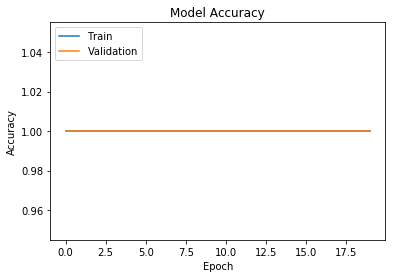

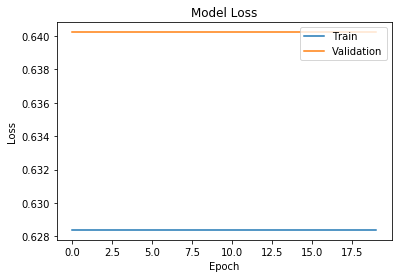

In [0]:
# Plot accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()